Machine learning INF284 Group Exam: Markus, Nikita, Bo og Andre

# Task 1 Machine learning on tabular mushrooms

# Task 2 Sentiment analysis 

# Task 3 Convolutional neural networks

In this task, the assignment is about training a convolutional neural network (CNN) as a binary classifier from the dataset that we have been provided with. This is a CIFAR-10 dataset that consists of 60000 images that are 32x32 colored images and will identify one of the following categories; airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Each of these has 6000 images that are divided into 50000 for the training model and 10000 for the testing model.

Info Box: Importing Required Libraries

In the following code block, we are importing the necessary libraries and modules to build and train the convolutional neural network (CNN) for binary image classification of task 3 using the Dataset of CIFAR-10. The following is a numerated list of imports with further explanations.

1. tensorflow: TensorFlow is an open-source machine learning library that helps us define and train neural network models.
2. VGG16: VGG16 is a pre-trained CNN architecture, which has proven to be effective for various image recognition tasks. We will use this as the base model for our classifier.

While researching for this assignment we found a couple of different pre-trained CNN models we could use for this project. Some of the choices were ResNet-50/101/152, Inception-v3/v4, MobileNetV1/V2/V3. A decision was made not to use these because of the computing power that would be unsatisfactory for some systems with the amount of layers that the models have. We landed upon the VGG16 model that is a deep CNN model that has 16 layers. It is a less complex model compared to the previous one we have mentioned, but it is more complex then a 3-5 layer CNN. We chose VGG16 at first because we ran into some errors while trying to create our own 3-5 layer CNN using a pre-trained CNN model that has strong performance in particular image classification.

3. image: The image module from the Keras preprocessing library helps us load and preprocess images from our dataset.
4. Model: This class allows us to create custom models by specifying the input and output layers.
5. Dense and GlobalAveragePooling2D: These are Keras layers that we'll use to modify the VGG16 model for our specific task.
6. Adam: The Adam optimizer is an optimization algorithm that helps us train our neural network.
7. numpy: NumPy is a library for numerical computing in Python. We'll use it for handling arrays and mathematical operations.
8. os: The os module provides a way of using operating system dependent functionality like reading or writing to the file system.
9. pickle: This module is used for serializing and de-serializing Python objects. We will use it to load the CIFAR-10 dataset.
10. matplotlib.pyplot: Matplotlib is a plotting library, and we will use it to visualize our dataset and training results. We will be plotting accuracy and validation loss to see when and if the data plateaus once we start training it.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

2023-04-27 14:38:16.188255: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 14:38:16.227693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:38:16.423927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:38:16.425357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:38:17.286968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Loading CIFAR-10 Dataset

In the following code block, we define a function called unpickle that is going to load our CIFAR-10 dataset files. The dataset is stored in a serialized format using the Python pickle module. This function accepts a file path as input and returns a dictionary containing the loaded data.

1. file: The file path of the CIFAR-10 dataset file to load.
2. fo: A file object created using the open() function to read the contents of the dataset file.
3. dict: A dictionary object containing the deserialized contents of the dataset file.

We use this function by simply passing the file path of a CIFAR-10 dataset file to it, and it will return a dictionary containing the loaded data.

In [2]:
# Define the function to load our dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Loading and Preprocessing CIFAR-10 Dataset

Further we load the data by defining a function called load_cifar10_data to load and preprocess the CIFAR-10 dataset. This function accepts the path to the data directory containing the dataset files and returns the preprocessed training and testing data along with their corresponding labels.

The function performs the following steps:

1. Iterate through the data batches 1 to 5 and load each batch using the unpickle function.
2. Stack the training data from all batches vertically using np.vstack.
3. Load the testing data using the unpickle function.
4. Reshape the training and testing data to match the desired dimensions (number of images, height, width, and channels) using numpy.reshape.
5. Rearrange the axes to match the format expected by the TensorFlow library using numpy.rollaxis.
6. Convert the training and testing labels to NumPy arrays.

We use this function by passing the path to the data directory containing the CIFAR-10 dataset files, and it will return the preprocessed training and testing data along with their corresponding labels.

In [3]:
# Load and preprocess the dataset
def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dict = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        if i == 1:
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

Loading CIFAR-10 Dataset into Variables

Further we are using the load_cifar10_data function to load and preprocess the CIFAR-10 dataset. We provide the data directory containing the dataset files as an argument to the function.

The function returns four arrays:

1. x_train: The preprocessed training data, a NumPy array of shape (number of training images, height, width, channels).
2. y_train: The training labels, a NumPy array of shape (number of training images,).
3. x_test: The preprocessed testing data, a NumPy array of shape (number of testing images, height, width, channels).
4. y_test: The testing labels, a NumPy array of shape (number of testing images,).

We store these arrays in the corresponding variables to use later in our neural network model training process.

In [4]:
data_dir = './cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

Preprocessing and Normalizing Input Data

In this code block, we perform further preprocessing on the input data and normalize the pixel values for both the training and testing sets.

We divide the pixel values by 255 to scale them to the range [0, 1]. This normalization helps improve the training process by ensuring that the input values are within a similar scale.

We choose a category (in this case, 0) for our binary classification task.

We convert the class labels for both training and testing sets to one-hot encoded vectors using the tf.keras.utils.to_categorical function. One-hot encoding is a representation method where the index of the target class is set to 1 and the remaining indices are set to 0. This is a preprocessing step for multi-class classification problems.

By normalizing the input data and converting the class labels to one-hot encoding, we prepare our dataset for training the CNN model.

In [5]:
# Preprocess input data, and normalize the input data 
x_train = x_train / 255.0
x_test = x_test / 255.0

chosen_category = 0

# Convert class labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Plotting Validation Loss

Here we define a function called plot_validation_loss to visualize the validation loss during the training process. This function accepts the training history object returned by the fit method when training a Keras model and generates a plot of the validation loss over epochs.

The function performs the following steps:

1. Use the plt.plot function to create a line plot of the validation loss stored in history.history['val_loss'].
2. Set the title, x-axis label, and y-axis label for the plot using plt.title, plt.xlabel, and plt.ylabel functions.
3. Add a legend to the plot using the plt.legend function, specifying the location of the legend as the upper right corner.
4. Display the plot using the plt.show function.

You can use this function to analyze the training process and identify any issues, such as overfitting or underfitting, based on the validation loss curve.

In [6]:
# Function to plot validation loss
def plot_validation_loss(history):
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Validation'], loc='upper right')
    plt.show()

Info Box: Loading the Pre-trained VGG16 Model

In the following code block we load the pre-trained VGG16 model using the VGG16 function from the tensorflow.keras.applications module. We will use this pre-trained model as the base for our binary image classifier.

The VGG16 function accepts the following arguments:

1. weights: The pre-trained weights to load. In this case, we use the 'imagenet' weights, which were trained on the ImageNet dataset.
2. include_top: A boolean value indicating whether to include the fully connected layers at the top of the network. We set this to False to exclude the original classification layer, as we will add our custom binary classification layer later.
3. input_shape: The shape of the input tensor. We provide a tuple with the desired input shape (32, 32, 3) since the CIFAR-10 images have a resolution of 32x32 pixels and 3 color channels.

After loading the VGG16 model, we store it in the base_model variable, which we will use to build our custom binary classifier.

In [7]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

2023-04-27 14:38:21.914656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Info Box: Modifying the VGG16 Model for Binary Classification

In this code block, we modify the pre-trained VGG16 model to create our binary image classifier. We follow these steps:

Add a global spatial average pooling layer: We take the output of the base VGG16 model (base_model.output) and pass it through a GlobalAveragePooling2D layer. This layer reduces the spatial dimensions of the feature maps by computing the average of all values in each channel. This operation significantly reduces the number of parameters and helps prevent overfitting.

Add a fully connected layer: We add a Dense layer with 1024 units and a ReLU activation function. This layer will learn higher-level features from the pooled feature maps.

Add the final output layer for binary classification: We replace the original 10-class softmax activation output layer with a single-unit Dense layer with a sigmoid activation function. The sigmoid activation function outputs a value between 0 and 1, representing the probability that the input image belongs to the chosen category.

In [8]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add the final output layer for 10-class classification
# predictions = Dense(10, activation='softmax')(x)
predictions = Dense(10, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Fine-tune only the top layers (freeze all convolutional layers)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Training the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 207s 132ms/step - loss: 1.4941 - accuracy: 0.4913 - val_loss: 1.3250 - val_accuracy: 0.5372
Epoch 2/5
1563/1563 [==============================] - 190s 122ms/step - loss: 1.2574 - accuracy: 0.5675 - val_loss: 1.2508 - val_accuracy: 0.5617
Epoch 3/5
1563/1563 [==============================] - 181s 116ms/step - loss: 1.1941 - accuracy: 0.5882 - val_loss: 1.2141 - val_accuracy: 0.5773
Epoch 4/5
1563/1563 [==============================] - 191s 122ms/step - loss: 1.1548 - accuracy: 0.6018 - val_loss: 1.1911 - val_accuracy: 0.5808
Epoch 5/5
1563/1563 [==============================] - 178s 114ms/step - loss: 1.1255 - accuracy: 0.6121 - val_loss: 1.1737 - val_accuracy: 0.5903


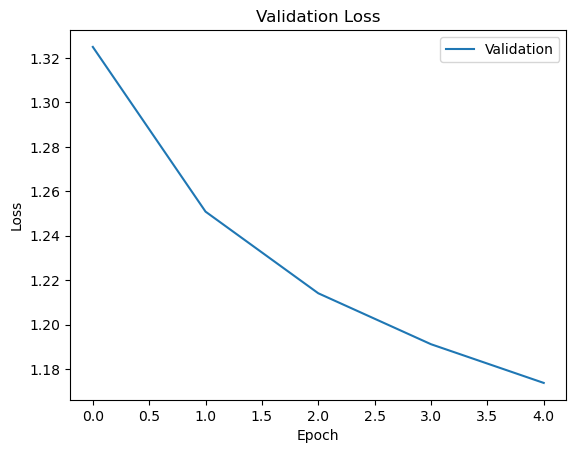

In [10]:
# Plotting the validation loss
plot_validation_loss(history)

In [11]:
# Load a new image and preprocess it
new_image_path = './new_images/picture_1.png'# Here is the pathing for the image so if you want to add an image just past it into this folder and change the name.
new_image = image.load_img(new_image_path, target_size=(32, 32))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0


In [12]:
# Predict the class of the new image
prediction = model.predict(new_image)
predicted_class = 1 if prediction[0][0] > 0.5 else 0


1/1 [==============================] - 0s 192ms/step


In [13]:
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
if predicted_class:
    print(f"The image is predicted to be an {categories[chosen_category]}.")
else:
    print(f"The image is predicted to not be an {categories[chosen_category]}.")

The image is predicted to be an airplane.
